In [15]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import gurobi_logtools as glt

In [16]:
name = "Reactor2"
PATH = f".\Experiments\{name}\Logs"

In [17]:
result = glt.parse(PATH+"\*.log")
summary = result.summary()


In [18]:

nl = result.progress("nodelog")
print(nl[~nl['Incumbent'].isna()])
nl.head()

     CurrentNode  RemainingNodes  Obj  Depth  IntInf  Incumbent    BestBd  \
27          1781          1335.0  NaN    NaN     NaN   0.065426  0.065430   
28          1781             NaN  NaN    NaN     NaN   0.065426  0.065426   
203            1             NaN  NaN    NaN     NaN   0.065426  0.065426   
233         1781          1335.0  NaN    NaN     NaN   0.065426  0.065430   
234         1781             NaN  NaN    NaN     NaN   0.065426  0.065426   
417            1             NaN  NaN    NaN     NaN   0.065426  0.065426   

     Gap  ItPerNode    Time Pruned NewSolution  \
27   0.0     1198.0  684.00    NaN           H   
28   0.0        NaN  684.22    NaN         NaN   
203  0.0        NaN    2.32    NaN         NaN   
233  0.0     1198.0  684.00    NaN           H   
234  0.0        NaN  684.56    NaN         NaN   
417  0.0        NaN    2.20    NaN         NaN   

                                       LogFilePath  LogNumber  Seed Version  
27   .\Experiments\Reactor2\Log

c:\Users\sian_\OneDrive\Documents\Thesis\Transformer_Formulation\pyomo_env\lib\site-packages\gurobi_logtools\api.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  left=pd.concat(progress),


,CurrentNode,RemainingNodes,Obj,Depth,IntInf,Incumbent,BestBd,Gap,ItPerNode,Time,Pruned,NewSolution,LogFilePath,LogNumber,Seed,Version
0,0,0.0,0.06543,0.0,1853.0,NaN,0.06543,NaN,NaN,3.0,NaN,NaN,.\Experiments\Reactor2\Logs\Reactor_r1_c1.log,1,0,11.0.2
1,0,0.0,0.06543,0.0,1861.0,NaN,0.06543,NaN,NaN,3.0,NaN,NaN,.\Experiments\Reactor2\Logs\Reactor_r1_c1.log,1,0,11.0.2
2,0,0.0,0.06543,0.0,1861.0,NaN,0.06543,NaN,NaN,3.0,NaN,NaN,.\Experiments\Reactor2\Logs\Reactor_r1_c1.log,1,0,11.0.2
3,0,0.0,0.06543,0.0,1810.0,NaN,0.06543,NaN,NaN,3.0,NaN,NaN,.\Experiments\Reactor2\Logs\Reactor_r1_c1.log,1,0,11.0.2
4,0,0.0,0.06543,0.0,1810.0,NaN,0.06543,NaN,NaN,4.0,NaN,NaN,.\Experiments\Reactor2\Logs\Reactor_r1_c1.log,1,0,11.0.2


In [19]:
regex_pattern = r'_r(\d+)_c(\d+)\.log'
nl[['Repetition', 'Config']] = nl['LogFilePath'].str.extract(regex_pattern)
nl.head()

,CurrentNode,RemainingNodes,Obj,Depth,IntInf,Incumbent,BestBd,Gap,ItPerNode,Time,Pruned,NewSolution,LogFilePath,LogNumber,Seed,Version,Repetition,Config
0,0,0.0,0.06543,0.0,1853.0,NaN,0.06543,NaN,NaN,3.0,NaN,NaN,.\Experiments\Reactor2\Logs\Reactor_r1_c1.log,1,0,11.0.2,1,1
1,0,0.0,0.06543,0.0,1861.0,NaN,0.06543,NaN,NaN,3.0,NaN,NaN,.\Experiments\Reactor2\Logs\Reactor_r1_c1.log,1,0,11.0.2,1,1
2,0,0.0,0.06543,0.0,1861.0,NaN,0.06543,NaN,NaN,3.0,NaN,NaN,.\Experiments\Reactor2\Logs\Reactor_r1_c1.log,1,0,11.0.2,1,1
3,0,0.0,0.06543,0.0,1810.0,NaN,0.06543,NaN,NaN,3.0,NaN,NaN,.\Experiments\Reactor2\Logs\Reactor_r1_c1.log,1,0,11.0.2,1,1
4,0,0.0,0.06543,0.0,1810.0,NaN,0.06543,NaN,NaN,4.0,NaN,NaN,.\Experiments\Reactor2\Logs\Reactor_r1_c1.log,1,0,11.0.2,1,1


In [53]:
import pandas as pd
import numpy as np

# Ensure columns are numeric, converting non-numeric entries to NaN
for col in ['Time', 'CurrentNode', 'NewSolution', 'Gap', 'Incumbent']:
    nl[col] = pd.to_numeric(nl[col], errors='coerce')

# Define helper functions for individual column aggregations
def time_to_first_feasible(series):
    feasible_times = series.dropna()
    return feasible_times.min() if not feasible_times.empty else np.nan

def solutions(series):
    feasible_times = series.dropna()
    return feasible_times.min() if not feasible_times.empty else np.nan

def final_value(series):
    valid_values = series.dropna()
    return valid_values.iloc[-1] if not valid_values.empty else np.nan

# Aggregate metrics per Config and Repetition
config_metrics = (
    nl.groupby(['Config', 'Repetition']).agg(
        Time_to_optimal=('Time', 'max'),
        Time_to_first_feasible=('Time', time_to_first_feasible),
        Nodes_explored=('CurrentNode', 'max'),
        Solutions_found=('NewSolution', 'mean'),
        Final_gap=('Gap', final_value),
        Objective_value=('Incumbent', final_value)
    )
    .reset_index()
)

# Average the metrics over the two repetitions for each configuration
average_metrics = config_metrics.groupby('Config').mean(numeric_only=True).reset_index()

# Display the resulting DataFrame
average_metrics.columns = [
    'Config', 'Avg_Time_to_optimal', 'Avg_Time_to_first_feasible', 'Avg_Nodes_explored',
    'Avg_Solutions_found', 'Avg_Final_gap', 'Avg_Objective_value'
]

average_metrics


,Config,Avg_Time_to_optimal,Avg_Time_to_first_feasible,Avg_Nodes_explored,Avg_Solutions_found,Avg_Final_gap,Avg_Objective_value
0,1,684.390,3.00,1781.0,NaN,0.0,0.065426
1,2,86400.045,3.00,121257.5,NaN,NaN,NaN
2,3,2.260,2.26,1.0,NaN,0.0,0.065426


In [54]:
grouped_nl = nl.groupby(['Config', 'Time']).agg({
    'Incumbent': ['mean', 'std'],
    'BestBd': ['mean', 'std'],
}).reset_index()

configs = grouped_nl['Config'].unique()
grouped_nl.head()

Config  Time Incumbent       BestBd     
                    mean std     mean  std
0      1   3.0       NaN NaN  0.06543  0.0
1      1   4.0       NaN NaN  0.06543  0.0
2      1   7.0       NaN NaN  0.06543  NaN
3      1   8.0       NaN NaN  0.06543  NaN
4      1  11.0       NaN NaN  0.06543  NaN

In [55]:
grouped_nl.columns = ['Config', 'Time', 'Incumbent_mean', 'Incumbent_std', 'BestBd_mean', 'BestBd_std']
grouped_nl.head()

,Config,Time,Incumbent_mean,Incumbent_std,BestBd_mean,BestBd_std
0,1,3.0,NaN,NaN,0.06543,0.0
1,1,4.0,NaN,NaN,0.06543,0.0
2,1,7.0,NaN,NaN,0.06543,NaN
3,1,8.0,NaN,NaN,0.06543,NaN
4,1,11.0,NaN,NaN,0.06543,NaN


In [44]:
combinations = {
    #'All': {'LN_I': 1, 'MHA_I': 1, 'MHA_D': 1, 'MHA_MC': 1},
    'No_MC': {'LN_I': 1, 'MHA_I': 1, 'MHA_D': 1, 'MHA_MC': 0}, #2
    'I_only': {'LN_I': 1, 'MHA_I': 1, 'MHA_D': 0, 'MHA_MC': 0}, #3
    # 'LN_only': {'LN_I': 1, 'MHA_I': 0, 'MHA_D': 0, 'MHA_MC': 0},
    # 'Prop_MC': {'LN_I': 1, 'MHA_I': 0, 'MHA_D': 1, 'MHA_MC': 1},
    'LN_prop': {'LN_I': 1, 'MHA_I': 0, 'MHA_D': 1, 'MHA_MC': 0}, #6
    #'None': {'LN_I': 0, 'MHA_I': 0, 'MHA_D': 0, 'MHA_MC': 0},
}


C:\Users\sian_\AppData\Local\Temp\ipykernel_20664\639452795.py:57: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(x_min, x_max)


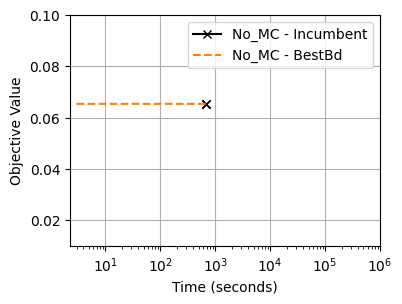

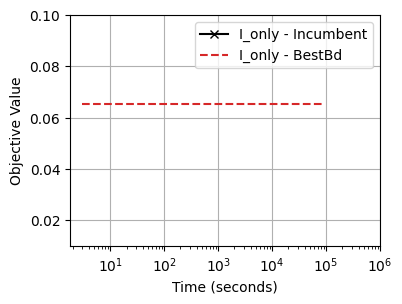

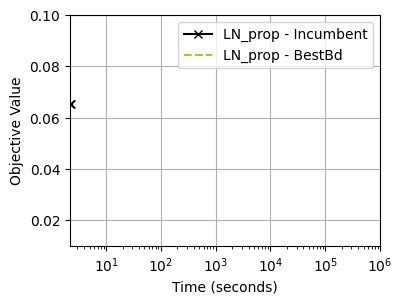

In [59]:
import matplotlib.pyplot as plt

# Initialize the figure size
colors = plt.get_cmap('tab10', len(grouped_nl['Config'].unique()))
colours = ['tab:orange', 'tab:red', 'tab:olive']

config_names = list(combinations.keys())

individ = False
if individ:
    grouped_nl = nl
    combi = grouped_nl[['Repetition', 'Config']].drop_duplicates()
    configs = combi.to_records(index=False).tolist()
    #combi = grouped_nl[['Config']].drop_duplicates()#grouped_nl[['Repetition', 'Config']].drop_duplicates()
    #configs = grouped_nl['Config'].unique()#combi.to_records(index=False).tolist()
else:
    # Find the global min and max values for both the x and y axes across all configurations
    x_min = 0#grouped_nl['Time'].min()
    x_max = 1e6 #grouped_nl['Time'].max()

    y_min = 1e-2 #min(grouped_nl['Incumbent_mean'].min(), grouped_nl['BestBd_mean'].min())
    y_max = 1e-1 #max(grouped_nl['Incumbent_mean'].max(), grouped_nl['BestBd_mean'].max())

# Plot each configuration using the same x and y axis limits
for i, config in enumerate(configs):
    plt.figure(i, figsize=(4, 3))
    print()

    # Plot Incumbent mean
    if not individ:
        color = colours[i]
        config_data = grouped_nl[grouped_nl['Config'] == config]
        # plt.fill_between(config_data['Time'], 
        #                 config_data['Incumbent_mean'] - config_data['Incumbent_std'], 
        #                 config_data['Incumbent_mean'] + config_data['Incumbent_std'], 
        #                 color=color, alpha=0.5)
        plt.plot(config_data['Time'], config_data['Incumbent_mean'], 'x-', label=f'{config_names[i]} - Incumbent', color='k')
        #Add shaded area for Incumbent std
        

        # # Plot BestBd mean
        # plt.fill_between(config_data['Time'], 
        #                 config_data['BestBd_mean'] - config_data['BestBd_std'], 
        #                 config_data['BestBd_mean'] + config_data['BestBd_std'], 
        #                 color="black", alpha=0.5)
        plt.plot(config_data['Time'], config_data['BestBd_mean'], linestyle='--', label=f'{config_names[i]} - BestBd', color=color)
    else:
        config_data = grouped_nl[(grouped_nl['Config'] == config[-1]) & (grouped_nl['Repetition'] == config[0])]
        plt.plot(config_data['Time'], config_data['Incumbent'], 'x-', label=f'{config}_{i}')
        plt.plot(config_data['Time'], config_data['BestBd'], linestyle='--', label=f'{config}_{i}')

    # Set to log scale
    #plt.yscale('log')
    plt.xscale('log')

    # # Set the same x and y limits for all plots
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Add labels
    plt.grid(True)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Objective Value')
    plt.legend()
    

    # PATH = r"C:\Users\sian_\OneDrive\Documents\Thesis"
    # plt.savefig(PATH+f'\images\{config_names[i]}_time_conv.png')  
    # #plt.show()
     


In [46]:
grouped_nl2 = nl.groupby(['Config', 'CurrentNode']).agg({
    'Incumbent': ['mean', 'std'],
    'BestBd': ['mean', 'std']
}).reset_index()

configs = grouped_nl2['Config'].unique()
grouped_nl2.columns = ['Config', 'Node', 'Incumbent_mean', 'Incumbent_std', 'BestBd_mean', 'BestBd_std']
grouped_nl2.head()

,Config,Node,Incumbent_mean,Incumbent_std,BestBd_mean,BestBd_std
0,1,0,NaN,NaN,0.06543,0.0
1,1,31,NaN,NaN,0.06543,0.0
2,1,51,NaN,NaN,0.06543,NaN
3,1,62,NaN,NaN,0.06543,NaN
4,1,100,NaN,NaN,0.06543,0.0


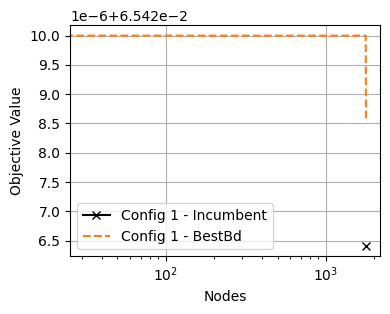

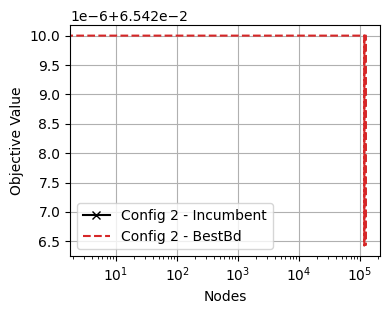

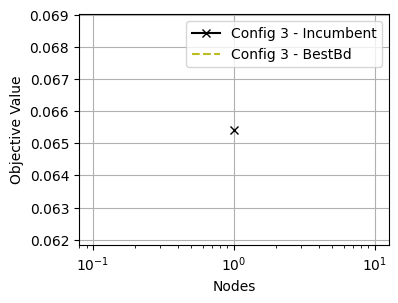

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the number of subplots based on the number of configurations
num_configs = len(configs)
# fig, axes = plt.subplots(nrows=2, ncols=(num_configs + 1) // 2, figsize=(15, 10))  # Adjust subplot grid

# Set the color map for the plots
colors = plt.get_cmap('tab10', num_configs)

# Find the global min and max values for the x and y axes across all configurations
# x_min = grouped_nl2['Node'].min()
#x_max = 0.1
# y_min = 1e-4
# y_max = max(grouped_nl2['Incumbent_mean'].max(), grouped_nl2['BestBd_mean'].max())

# # Flatten axes array for easy iteration
# axes = axes.flatten()

# Plot each configuration in a separate subplot
for i, config in enumerate(configs):
    plt.figure(i, figsize=(4, 3))
    config_data = grouped_nl2[grouped_nl2['Config'] == config]
    color = colours[i]

    # Plot Incumbent mean
    plt.plot(config_data['Node'], config_data['Incumbent_mean'], 'x-',label=f'Config {config} - Incumbent', color='k')
    # Add shaded area for Incumbent std
    # plt.fill_between(config_data['Node'], 
    #                 config_data['Incumbent_mean'] - config_data['Incumbent_std'], 
    #                 config_data['Incumbent_mean'] + config_data['Incumbent_std'], 
    #                 color=color, alpha=0.2)

    # Plot BestBd mean
    plt.plot(config_data['Node'], config_data['BestBd_mean'], linestyle='--', label=f'Config {config} - BestBd', color=color)
    # Add shaded area for BestBd std
    # plt.fill_between(config_data['Node'], 
    #                 config_data['BestBd_mean'] - config_data['BestBd_std'], 
    #                 config_data['BestBd_mean'] + config_data['BestBd_std'], 
    #                 color=color, alpha=0.2)

    # Set to log scale
    #plt.yscale('log')
    plt.xscale('log')

    # # Set the same x and y limits for all plots
    #plt.xlim(x_min, x_max)
    #plt.ylim(y_min, y_max)

    # Add labels and grid
    plt.xlabel('Nodes')
    plt.ylabel('Objective Value')
    plt.grid(True)
    plt.legend()

    plt.show()

# # Set the title for the entire figure
# fig.suptitle('Bound Convergence Over Nodes (Log Scale)', fontsize=16)

# # Adjust layout to prevent overlapping
# plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
# plt.show()

# # Optionally, save the figure
# PATH = r"C:\Users\sian_\OneDrive\Documents\Thesis"
# plt.savefig(PATH + r'\images\bound_convergence_nodes_subplots.png')
